<a href="https://colab.research.google.com/github/mjn6862/Freiburg_dataset/blob/master/Warping_for_PoseNet_Freiburg%2C_warping_only_(no_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Statements**

In [ ]:
!pip install tensorflow_graphics

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
from datetime import datetime
import csv
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Define the input layers**

**Create HTM from 6x1**

Equations taken from DVO paper

**Define the model**

In [2]:
input_A = tf.keras.layers.Input(shape=(480, 640, 3), name="first_image")
depth_A = tf.keras.layers.Input(shape=(480, 640, 1), name="first_depth")
input_B = tf.keras.layers.Input(shape=(480, 640, 3), name="second_image")
depth_B = tf.keras.layers.Input(shape=(480, 640, 1), name="second_depth")

**Starting here: layers to go from 6-dim vector to 4x4 HTM within model**


In [3]:
input_xi = tf.keras.layers.Input(shape=(6), name="xi")
input_pose = tf.keras.layers.Flatten()(input_xi) # just a layer that will make things easier to connect later; replace input_xi with readout to connect to bigger model

In [4]:
def exp_mat(input_pose):
  '''
  Takes an input_pose = [omega nu] and returns the corresponding homogeneous
  transformation matrix, within a tf.keras model.
  inputs:
    input_pose: a (None,6) tensor output from a layer of a tf.keras model
  outputs:
    exp_xi: a (None,4,4) tensor output from a layer of a tf.keras model
  '''
  # create 3x3 matrix omega_x from xi=[omega nu]
  omega_x_weights = np.zeros([6,9])
  omega_x_weights[0,5]=-1
  omega_x_weights[0,7]=1
  omega_x_weights[1,2]=1
  omega_x_weights[1,6]=-1
  omega_x_weights[2,1]=-1
  omega_x_weights[2,3]=1

  omega_x = tf.keras.layers.Dense(9,use_bias=False,weights=[omega_x_weights],trainable=False)(input_pose)
  omega_x = tf.keras.layers.Reshape((3,3))(omega_x)

  # create 3-dimensional vector nu from xi=[omega nu]
  nu_weights = np.zeros([6,3])
  nu_weights[3,0]=1
  nu_weights[4,1]=1
  nu_weights[5,2]=1

  nu = tf.keras.layers.Dense(3,use_bias=False,weights=[nu_weights],trainable=False)(input_pose)
  nu = tf.keras.layers.Reshape((3,1))(nu)

  xi_hat = tf.keras.layers.concatenate([omega_x,nu])
  xi_hat = tf.keras.layers.ZeroPadding1D(padding=(0,1))(xi_hat)
  exp_xi = tf.keras.layers.Lambda(tf.linalg.expm)(xi_hat)
  return exp_xi

In [5]:
exp_xi_layer = exp_mat(input_pose)

In [214]:
#xi = tf.constant([np.random.rand(6),np.random.rand(6)])
xi = tf.constant([np.array([0.1,0.2,0.3,1,2,3])])
htm_model = tf.keras.models.Model(inputs=[input_xi],outputs=[exp_xi_layer])
print(htm_model.predict([xi]))

[[[ 9.35754803e-01 -2.83164961e-01  2.10191706e-01  1.00000000e+00]
  [ 3.02932713e-01  9.50580618e-01 -6.80313164e-02  2.00000000e+00]
  [-1.80540077e-01  1.27334575e-01  9.75290309e-01  3.00000000e+00]
  [-5.86732144e-17 -3.29417057e-17 -7.56747146e-17  1.00000000e+00]]]


**Here starts the attempts to warp from input_A, depth_A, and exp_xi**

In [6]:
# Define hx, wx, h1 as the homogeneous pixel coordinates
# This appears to match the original paper's output format
height_coord = range(480)
width_coord = range(640)
hx, wx = pixel_coord = np.meshgrid(height_coord, width_coord, indexing='ij')
hx = hx.reshape((480, 640, 1))
wx = wx.reshape((480, 640, 1))
h1 = np.ones(hx.shape)

grid = np.concatenate((hx, wx, h1), axis=-1)

# Define the camera intrinsic matrix
#K = np.array([[525.,0.,319.5], [0., 525., 239.5], [0.,0.,1.]])  # This is how the rostopic defines it
K = np.array([[525.,0.,239.5], [0., 525., 319.5], [0.,0.,1.]])

# Define the camera coordinates of each piel up to a depth scale factor
unscaled_cam_coord = np.empty(grid.shape)
for i in range(480):
      for j in range(640):
        unscaled_cam_coord[i,j,:]= np.linalg.inv(K).dot(grid[i,j,:])

In [7]:
def warp_image(image1,depth1,htm):
  '''
  Use an htm and depth1 to warp image1 in a keras model.
  inputs:
    image1: a (None,480,640,3) tensor
    depth1: a (None,480,640,1) tensor
    htm: a (None,4,4) tensor
  output:
    new_image: a (None,480,640,3) tensor
  '''
  camera_coord = tf.keras.layers.Reshape((307200,1),name='camera_coord1')(depth_A)
  def camera_coord_fun(depth):
    return depth*unscaled_cam_coord.reshape(307200,3)
    
  camera_coord = tf.keras.layers.Lambda(camera_coord_fun,name='camera_coord2')(camera_coord)

  # Here's an annoying way to get an output of all ones.  Just take a matrix of the appropriate size to the power zero element-wise
  ones_layer = tf.keras.layers.Flatten(name='ones1')(depth_A)
  def ones_fun(depth):
    return tf.math.pow(depth,0)
  ones_layer = tf.keras.layers.Lambda(ones_fun,name='ones2')(ones_layer)
  ones_layer = tf.keras.layers.Reshape((307200,1),name='ones3')(ones_layer)

  homog_camera_coord = tf.keras.layers.concatenate([camera_coord, ones_layer],name='homog_camera_coord')

  # new_homog_camera_coord = tf.keras.backend.dot(homog_camera_coord, tf.keras.backend.transpose(tf.reshape(delta_pose,(4,4))))
  # new_homog_camera_coord = tf.math.divide(new_homog_camera_coord, tf.reshape(new_homog_camera_coord[:,2], (307200,1)) ) 
  new_homog_camera_coord = tf.keras.layers.Dot(axes=(2,2),name='new_homog_camera_coord1')([homog_camera_coord,exp_xi_layer]) # not sure if axes value is correct, but the output has all ones on the right side, so it's probably right

  new_coord_depth1 = tf.keras.layers.Lambda(lambda coord: coord[:,:,2],name='new_coord_depth1')(new_homog_camera_coord)
  new_coord_depth2 = tf.keras.layers.Reshape((307200,1),name='new_coord_depth2')(new_coord_depth1)
  def new_homog_camera_coord_fun(x):
    return tf.math.divide(x[0],x[1])
  new_homog_camera_coord = tf.keras.layers.Lambda(new_homog_camera_coord_fun,name='new_homog_camera_coord2')((new_homog_camera_coord,new_coord_depth2))
  new_homog_camera_coord = tf.keras.layers.Lambda(lambda coord: coord[:,:,0:3],name='new_homog_camera_coord3')(new_homog_camera_coord)

  #  pixel_list = tf.keras.backend.dot(tf.reshape(new_homog_camera_coord[:,0:3],(307200,3)), tf.keras.backend.transpose(K))
  # I guess I need to create a layer corresponding to K first
  # I used a layer with 1 neuron as an intermediary to avoid too many weights
  K_layer = tf.keras.layers.Flatten(name='K1')(depth_A)
  K_layer = tf.keras.layers.Dense(1,use_bias=False,weights=[np.zeros([307200,1])],trainable=False,name='K2')(K_layer)
  K_layer = tf.keras.layers.Dense(9,weights=[np.zeros([1,9]),K.reshape(9)],trainable=False,name='K3')(K_layer)
  K_layer = tf.keras.layers.Reshape((3,3),name='K4')(K_layer)

  pixel_list = tf.keras.layers.Dot(axes=(2,2),name='pixel_list1')([new_homog_camera_coord,K_layer]) # not sure if axes value is correct
  pixel_list2 = tf.keras.layers.Lambda(lambda pix: pix[:,:,0:2],name='pixel_list2')(pixel_list)
  #pixel_list = tf.keras.layers.Reshape((1,307200,2))(pixel_list)

  # interp = tfa.image.interpolate_bilinear(grid=tf.reshape(image1[-1, :, :, :], (1, 480, 640,3)), query_points=tf.reshape(pixel_list[:,0:2], (-1,307200,2)))
  def interp_fun(x):
    return tfa.image.interpolate_bilinear(grid=tf.reshape(x[0],(-1,480,640,3)),query_points=tf.reshape(x[1],(-1,307200,2)))
  interp = tf.keras.layers.Lambda(interp_fun,name='interp')((input_A,pixel_list2))
  new_image = tf.keras.layers.Reshape((480,640,3),name='new_image')(interp)

  return new_image

In [8]:
new_image = warp_image(input_A,depth_A,exp_xi_layer)

In [13]:
w = tf.constant([np.random.rand(480,640,3),np.random.rand(480,640,3)])
x = tf.constant([np.random.rand(480,640,1),np.random.rand(480,640,1)])
y = tf.constant([np.random.rand(6),np.random.rand(6)])
model = tf.keras.models.Model(inputs=[input_A,depth_A,input_xi],outputs=[new_image])
model.predict([w,x,y]).shape

(2, 480, 640, 3)

In [9]:
frame = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/images/rgbd_10900.npy")
image1 = frame[:,:,0:3]/255.
depth1 = frame[:,:,3]*5./255.
depth1 = np.where(depth1==0,10., depth1)
image1 = tf.constant([image1])
depth1 = tf.constant([depth1])

In [10]:
xi = tf.constant([[0,0,0.3,0,0,0]])
#xi = tf.constant([np.random.rand(6)])
model = tf.keras.models.Model(inputs=[input_A,depth_A,input_xi],outputs=[new_image])
pred = model.predict([image1,depth1,xi])

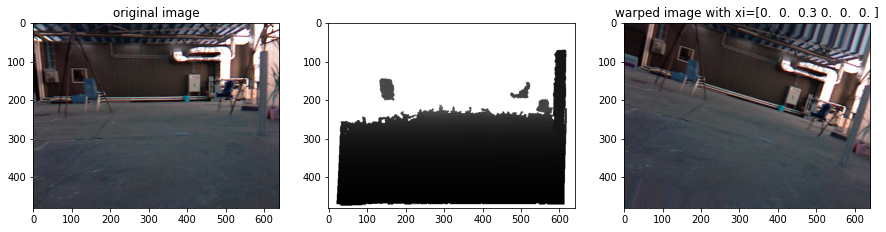

In [11]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(image1[0])
plt.title('original image')
plt.subplot(1,3,2)
plt.imshow(depth1[0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(pred[0])
plt.title('warped image with xi={}'.format(xi[0]))
plt.show()